# EDB: Layout Components

This example shows how you can use EDB to create a parametric component using
3D Layout and use it in HFSS 3D.

## Perform required imports

Perform required imports, which includes importing the ``Hfss3dlayout`` object
and initializing it on version 2023 R2.

In [1]:
import os
import tempfile

import ansys.aedt.core

import pyedb


## Set non-graphical mode

In [2]:
non_graphical = False

## Create data classes

Data classes are useful to do calculations and store variables.
There are three data classes: ``Patch``, ``Line``, and ``Array``.

In [3]:
class Patch:
    def __init__(self, width=0.0, height=0.0, position=0.0):
        self.width = width
        self.height = height
        self.position = position

    @property
    def points(self):
        return [
            [self.position, "-{}/2".format(self.height)],
            ["{} + {}".format(self.position, self.width), "-{}/2".format(self.height)],
            ["{} + {}".format(self.position, self.width), "{}/2".format(self.height)],
            [self.position, "{}/2".format(self.height)],
        ]


class Line:
    def __init__(self, length=0.0, width=0.0, position=0.0):
        self.length = length
        self.width = width
        self.position = position

    @property
    def points(self):
        return [
            [self.position, "-{}/2".format(self.width)],
            ["{} + {}".format(self.position, self.length), "-{}/2".format(self.width)],
            ["{} + {}".format(self.position, self.length), "{}/2".format(self.width)],
            [self.position, "{}/2".format(self.width)],
        ]


class LinearArray:
    def __init__(self, nb_patch=1, array_length=10e-3, array_width=5e-3):
        self.nbpatch = nb_patch
        self.length = array_length
        self.width = array_width

    @property
    def points(self):
        return [
            [-1e-3, "-{}/2-1e-3".format(self.width)],
            ["{}+1e-3".format(self.length), "-{}/2-1e-3".format(self.width)],
            ["{}+1e-3".format(self.length), "{}/2+1e-3".format(self.width)],
            [-1e-3, "{}/2+1e-3".format(self.width)],
        ]

## Launch EDB

PyEDB.Edb allows to open existing Edb project or create a new empty project.

In [4]:
temp_dir = tempfile.TemporaryDirectory(suffix=".ansys")
aedb_path = os.path.join(temp_dir.name, "linear_array.aedb")

# Select EDB version (change it manually if needed, e.g. "2024.2")
edb_version = "2024.2"
print(f"EDB version: {edb_version}")

# Create an instance of the Edb class.
edb = pyedb.Edb(edbpath=aedb_path, edbversion=edb_version)

EDB version: 2024.2


PyAEDT INFO: Logger is initialized in EDB.


PyAEDT INFO: legacy v0.37.0


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: EDB C:\Users\ansys\AppData\Local\Temp\tmp1z0tfsuo.ansys\linear_array.aedb created correctly.


PyAEDT INFO: EDB initialized.


In [5]:
# Add stackup layers
layers = {
    "materials": {"copper_high_cond": {"conductivity": 60000000}},
    "layers": {
        "TOP": {"type": "signal", "thicness": "35um", "material": "copper_high_cond"},
        "Substrat": {"type": "dielectric", "thicness": "0.5mm", "material": "Duroid (tm)"},
        "GND": {"type": "signal", "thicness": "35um", "material": "copper"},
        "Gap": {"type": "dielectric", "thicness": "0.05mm", "material": "Air"},
        "Virt_GND": {"type": "signal", "thicness": "35um", "material": "copper"},
    },
}

In [6]:
edb.stackup.load(layers)

True

Create the first patch and feed line using the ``Patch``, ``Line``classes defined above.

Define parameters:

In [7]:
edb["w1"] = 1.4e-3
edb["h1"] = 1.2e-3
edb["initial_position"] = 0.0
edb["l1"] = 2.4e-3
edb["trace_w"] = 0.3e-3

first_patch = Patch(width="w1", height="h1", position="initial_position")
edb.modeler.create_polygon(first_patch.points, "TOP", net_name="Array_antenna")

First line

In [8]:
first_line = Line(length="l1", width="trace_w", position=first_patch.width)
edb.modeler.create_polygon(first_line.points, "TOP", net_name="Array_antenna")

Now use the ``LinearArray`` class to create the array.

In [9]:
edb["w2"] = 2.29e-3
edb["h2"] = 3.3e-3
edb["l2"] = 1.9e-3
edb["trace_w2"] = 0.2e-3

patch = Patch(width="w2", height="h2")
line = Line(length="l2", width="trace_w2")
linear_array = LinearArray(nb_patch=8, array_width=patch.height)

current_patch = 1
current_position = "{} + {}".format(first_line.position, first_line.length)

while current_patch <= linear_array.nbpatch:
    patch.position = current_position
    edb.modeler.create_polygon(patch.points, "TOP", net_name="Array_antenna")
    current_position = "{} + {}".format(current_position, patch.width)
    if current_patch < linear_array.nbpatch:
        line.position = current_position
        edb.modeler.create_polygon(line.points, "TOP", net_name="Array_antenna")
        current_position = "{} + {}".format(current_position, line.length)
    current_patch += 1

linear_array.length = current_position

Add the ground conductor.

In [10]:
edb.modeler.create_polygon(linear_array.points, "GND", net_name="GND")

Add the connector pin to use to assign the port.

In [11]:
edb.padstacks.create(padstackname="Connector_pin", holediam="100um", paddiam="0", antipaddiam="200um")
con_pin = edb.padstacks.place(
    ["{}/4.0".format(first_patch.width), 0],
    "Connector_pin",
    net_name="Array_antenna",
    fromlayer="TOP",
    tolayer="GND",
    via_name="coax",
)

PyAEDT INFO: Padstack Connector_pin create correctly


Add a connector ground.

In [12]:
edb.modeler.create_polygon(first_patch.points, "Virt_GND", net_name="GND")
edb.padstacks.create("gnd_via", "100um", "0", "0")
edb["via_spacing"] = 0.2e-3
con_ref1 = edb.padstacks.place(
    [
        "{} + {}".format(first_patch.points[0][0], "via_spacing"),
        "{} + {}".format(first_patch.points[0][1], "via_spacing"),
    ],
    "gnd_via",
    fromlayer="GND",
    tolayer="Virt_GND",
    net_name="GND",
)
con_ref2 = edb.padstacks.place(
    [
        "{} + {}".format(first_patch.points[1][0], "-via_spacing"),
        "{} + {}".format(first_patch.points[1][1], "via_spacing"),
    ],
    "gnd_via",
    fromlayer="GND",
    tolayer="Virt_GND",
    net_name="GND",
)
con_ref3 = edb.padstacks.place(
    [
        "{} + {}".format(first_patch.points[2][0], "-via_spacing"),
        "{} + {}".format(first_patch.points[2][1], "-via_spacing"),
    ],
    "gnd_via",
    fromlayer="GND",
    tolayer="Virt_GND",
    net_name="GND",
)
con_ref4 = edb.padstacks.place(
    [
        "{} + {}".format(first_patch.points[3][0], "via_spacing"),
        "{} + {}".format(first_patch.points[3][1], "-via_spacing"),
    ],
    "gnd_via",
    fromlayer="GND",
    tolayer="Virt_GND",
    net_name="GND",
)

PyAEDT INFO: Padstack gnd_via create correctly


Define the port.

In [13]:
edb.padstacks.set_solderball(con_pin, "Virt_GND", isTopPlaced=False, ballDiam=0.1e-3)
port_name = edb.padstacks.create_coax_port(con_pin)

Display the model using the ``Edb.nets.plot()`` method.

PyAEDT INFO: Plot Generation time 0.141


(<Figure size 6000x3000 with 1 Axes>, <Axes: title={'center': 'Edb Top View'}>)

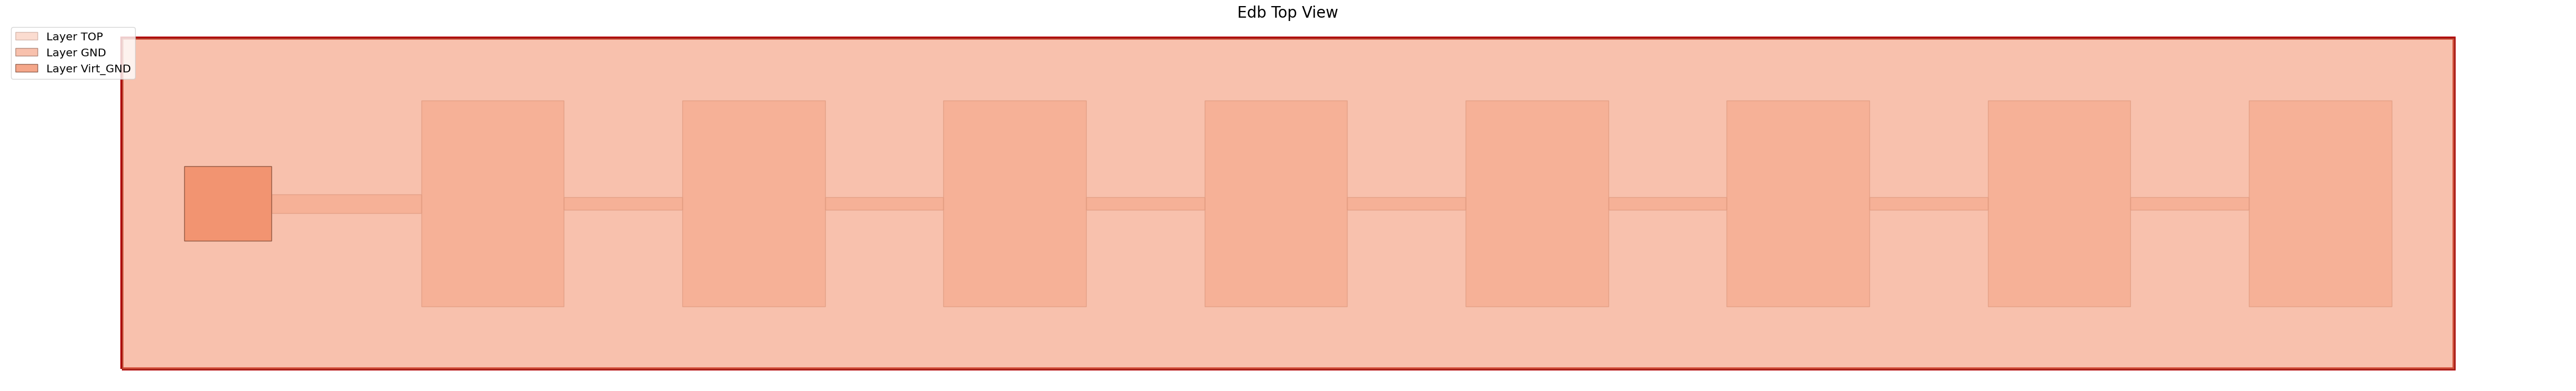

In [14]:
edb.nets.plot()

The EDB is complete. Now close the EDB and import it into HFSS as a "Layout Component".

In [15]:
edb.save_edb()
edb.close_edb()
print("EDB saved correctly to {}. You can import in AEDT.".format(aedb_path))

PyAEDT INFO: EDB file save time: 0.00ms


PyAEDT INFO: EDB file release time: 0.00ms


EDB saved correctly to C:\Users\ansys\AppData\Local\Temp\tmp1z0tfsuo.ansys\linear_array.aedb. You can import in AEDT.


## 3D component in HFSS

First create an instance of the ``pyaedt.Hfss`` class. If you set
> ``non_graphical = False

then AEDT user interface will be visible after the following cell is executed.
It is now possible to monitor the progress in the UI as each of the following cells is executed.
All commands can be run without the UI by changing the value of ``non_graphical``.

In [16]:
h3d = ansys.aedt.core.Hfss(
    projectname="Demo_3DComp",
    designname="Linear_Array",
    specified_version="2024.2",
    new_desktop_session=True,
    non_graphical=non_graphical,
    close_on_exit=True,
    solution_type="Terminal",
)

PyAEDT WARNING: Argument `designname` is deprecated for method `__init__`; use `design` instead.


PyAEDT WARNING: Argument `projectname` is deprecated for method `__init__`; use `project` instead.


PyAEDT WARNING: Argument `specified_version` is deprecated for method `__init__`; use `version` instead.


PyAEDT WARNING: Argument `new_desktop_session` is deprecated for method `__init__`; use `new_desktop` instead.


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.14.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_b8e9b902-36ef-4e83-9146-85f9a7164c50.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 53386


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 7484.


PyAEDT INFO: Project Demo_3DComp has been created.


PyAEDT INFO: Added design 'Linear_Array' of type HFSS.


PyAEDT INFO: Aedt Objects correctly read


Set units to ``mm``.

In [17]:
h3d.modeler.model_units = "mm"

PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


## Import the EDB as a 3D component

One or more layout components can be imported into HFSS.
The combination of layout data and 3D CAD data helps streamline model creation and setup.

In [18]:
component = h3d.modeler.insert_layout_component(aedb_path, parameter_mapping=True)

PyAEDT INFO: Logger is initialized in EDB.


PyAEDT INFO: legacy v0.37.0


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: Database linear_array.aedb Opened in 2024.2


PyAEDT INFO: Cell Cell_TW6U5R Opened


PyAEDT INFO: Builder was initialized.


PyAEDT INFO: EDB initialized.


PyAEDT INFO: Parsing C:/Users/ansys/Documents/Ansoft/Demo_3DComp.aedt.


PyAEDT INFO: File C:/Users/ansys/Documents/Ansoft/Demo_3DComp.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.015622377395629883


PyAEDT INFO: Logger is initialized in EDB.


PyAEDT INFO: legacy v0.37.0


PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT WARNING: AEDT project-related file C:\Users\ansys\Documents\Ansoft\Demo_3DComp.aedb\LayoutComponents\linear_array0\linear_array0.aedt.lock exists and may need to be deleted before opening the EDB in HFSS 3D Layout.


PyAEDT INFO: Database linear_array0.aedb Opened in 2024.2


PyAEDT INFO: Cell Cell_TW6U5R Opened


PyAEDT INFO: Builder was initialized.


PyAEDT INFO: EDB initialized.


## Expose the component parameters

If a layout component is parametric, you can expose and change parameters in HFSS

In [19]:
component.parameters

w1_name = "{}_{}".format("w1", h3d.modeler.user_defined_component_names[0])
h3d[w1_name] = 0.0015

### Radiation Boundary Assignment

The 3D domain includes the air volume surrounding the antenna.
This antenna will be simulted from 20 GHz - 50 GHz.

A "radiation boundary" will be assigned to the outer boundaries of the domain.
This boundary should be roughly one quarter wavelength away from the radiating structure:

$$ \lambda/4 = \frac{c_0}{4 f} \approx 2.8mm $$

In [20]:
h3d.modeler.fit_all()

h3d.modeler.create_air_region(2.8, 2.8, 2.8, 2.8, 2.8, 2.8, is_percentage=False)
h3d.assign_radiation_boundary_to_objects("Region")

PyAEDT INFO: Boundary Radiation Rad__YQYZ4X has been correctly created.


### Set up analysis

The finite element mesh is adapted iteratively.
The maximum number of adaptive passes is set using the ``MaximumPasses`` property.
This model converges such that the $S_{11}$ is independent of the mesh.
The default accuracy setting is:
$$ \max(|\Delta S|) < 0.02 $$

In [21]:
setup = h3d.create_setup()
setup.props["Frequency"] = "20GHz"
setup.props["MaximumPasses"] = 10

Specify properties of the frequency sweep:

In [22]:
sweep1 = setup.add_sweep(sweepname="20GHz_to_50GHz")
sweep1.props["RangeStart"] = "20GHz"
sweep1.props["RangeEnd"] = "50GHz"
sweep1.update()

PyAEDT WARNING: Argument `sweepname` is deprecated for method `add_sweep`; use `name` instead.


True

Solve the project

In [23]:
h3d.analyze()

PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


PyAEDT INFO: Solving all design setups.


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS correctly changed.


PyAEDT INFO: Design setup None solved correctly in 0.0h 3.0m 2.0s


True

## Plot results outside AEDT

Plot results using Matplotlib.

PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Solution Data Correctly Loaded.


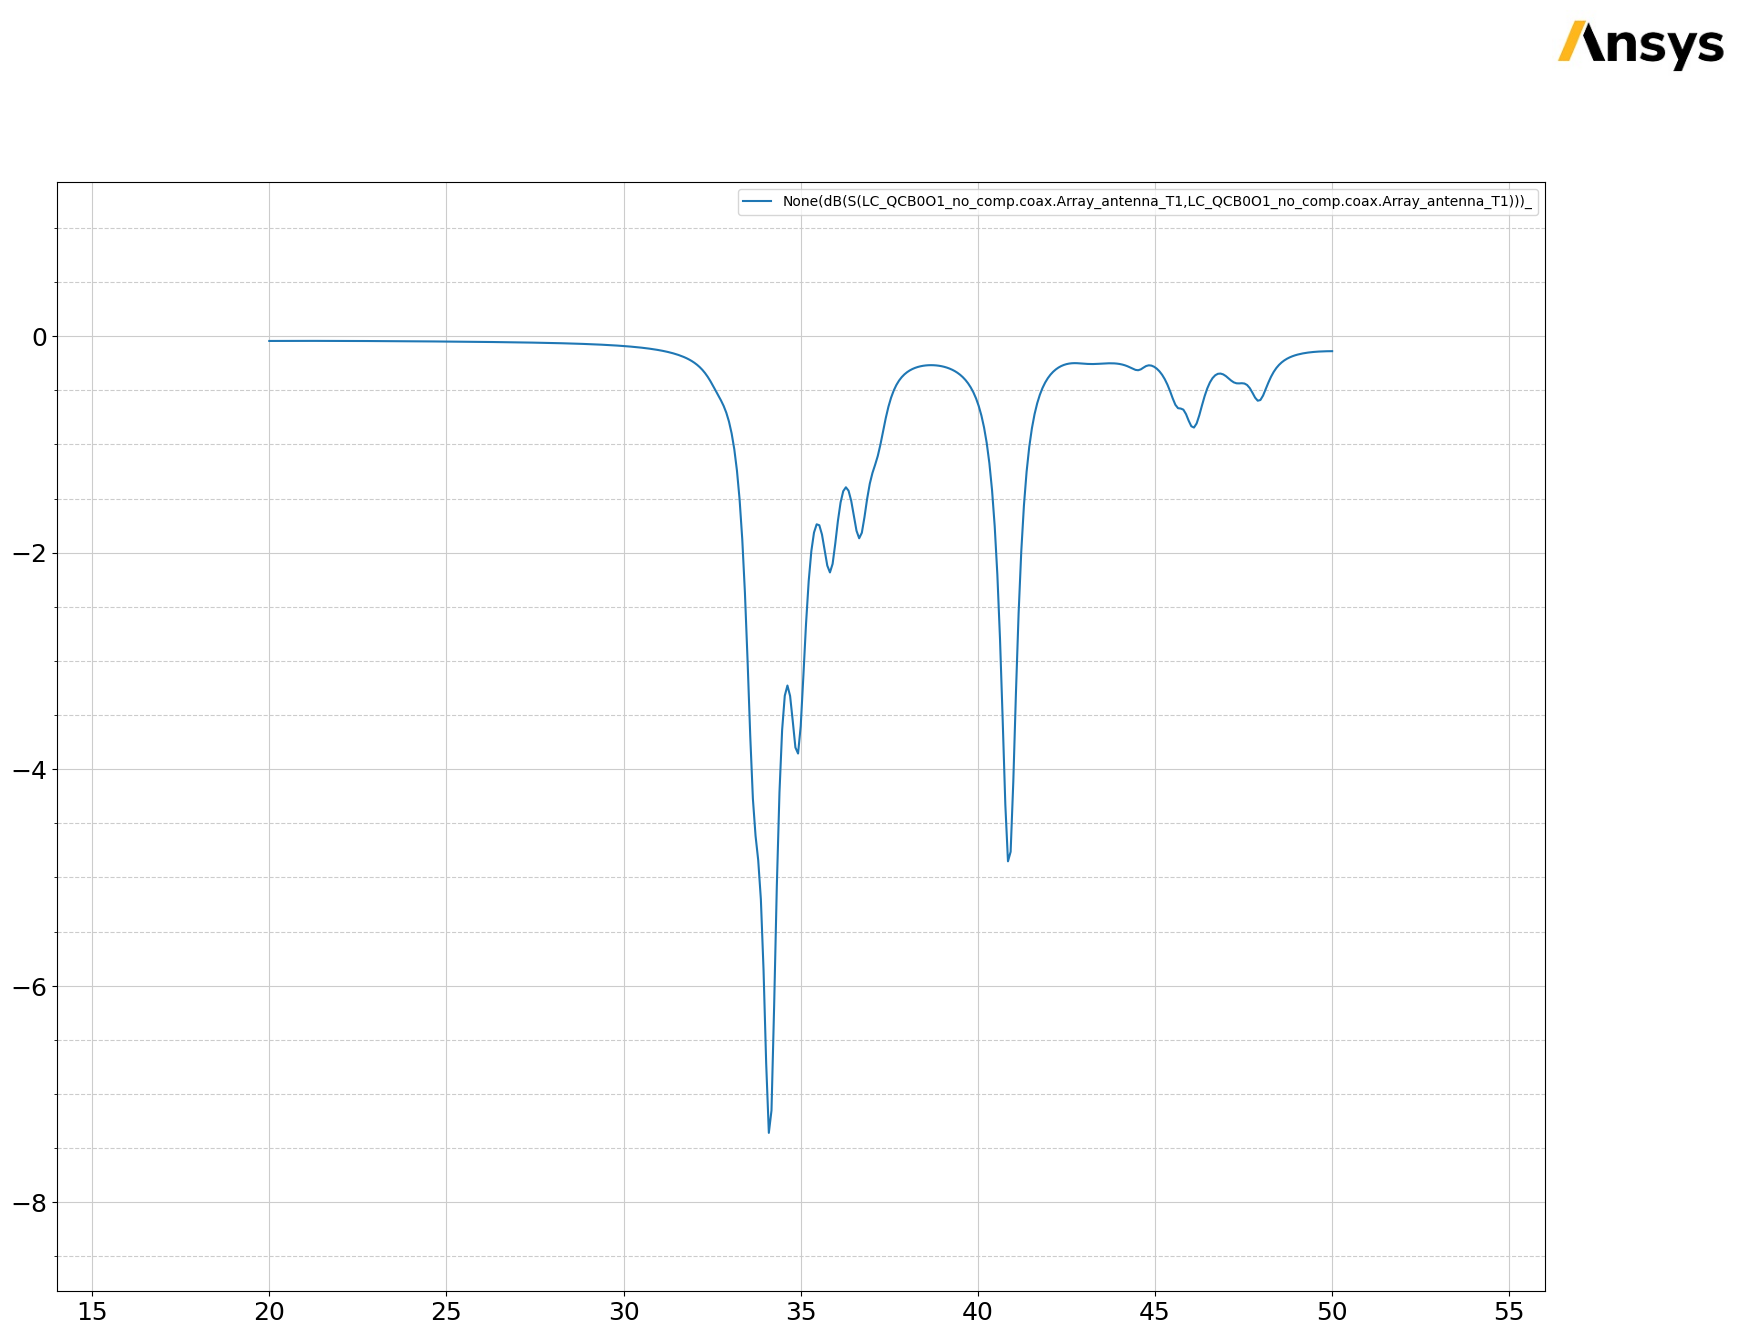

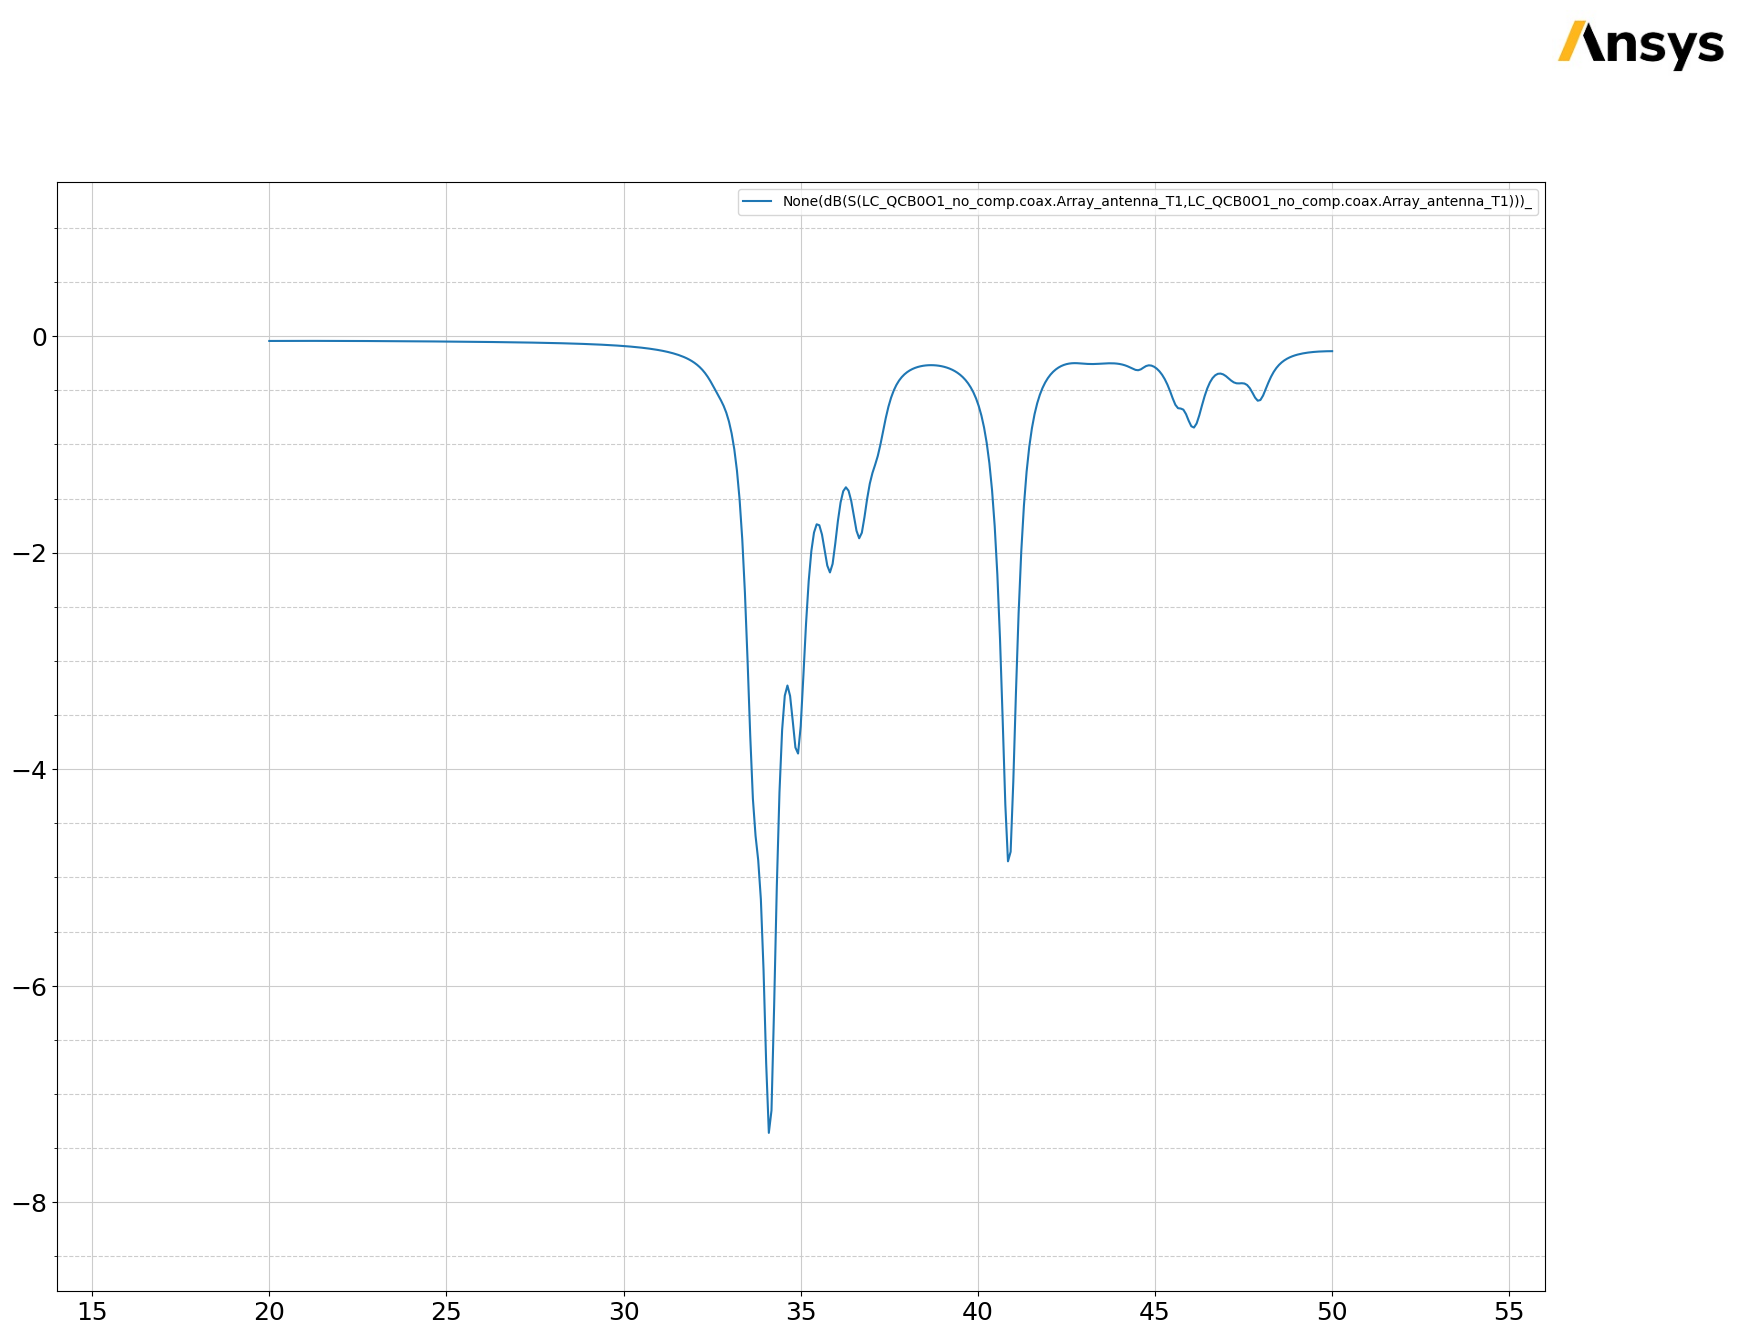

In [24]:
trace = h3d.get_traces_for_plot()
solution = h3d.post.get_solution_data(trace[0])
solution.plot()

## Plot far fields in AEDT

Plot radiation patterns in AEDT.

In [25]:
variations = {}
variations["Freq"] = ["20GHz"]
variations["Theta"] = ["All"]
variations["Phi"] = ["All"]
h3d.insert_infinite_sphere(name="3D")

new_report = h3d.post.reports_by_category.far_field("db(RealizedGainTotal)", h3d.nominal_adaptive, "3D")
new_report.variations = variations
new_report.primary_sweep = "Theta"
new_report.create("Realized2D")

True

## Plot far fields in AEDT

Plot radiation patterns in AEDT

In [26]:
new_report.report_type = "3D Polar Plot"
new_report.secondary_sweep = "Phi"
new_report.create("Realized3D")

True

## Plot far fields outside AEDT

Plot radiation patterns outside AEDT

PyAEDT INFO: Solution Data Correctly Loaded.


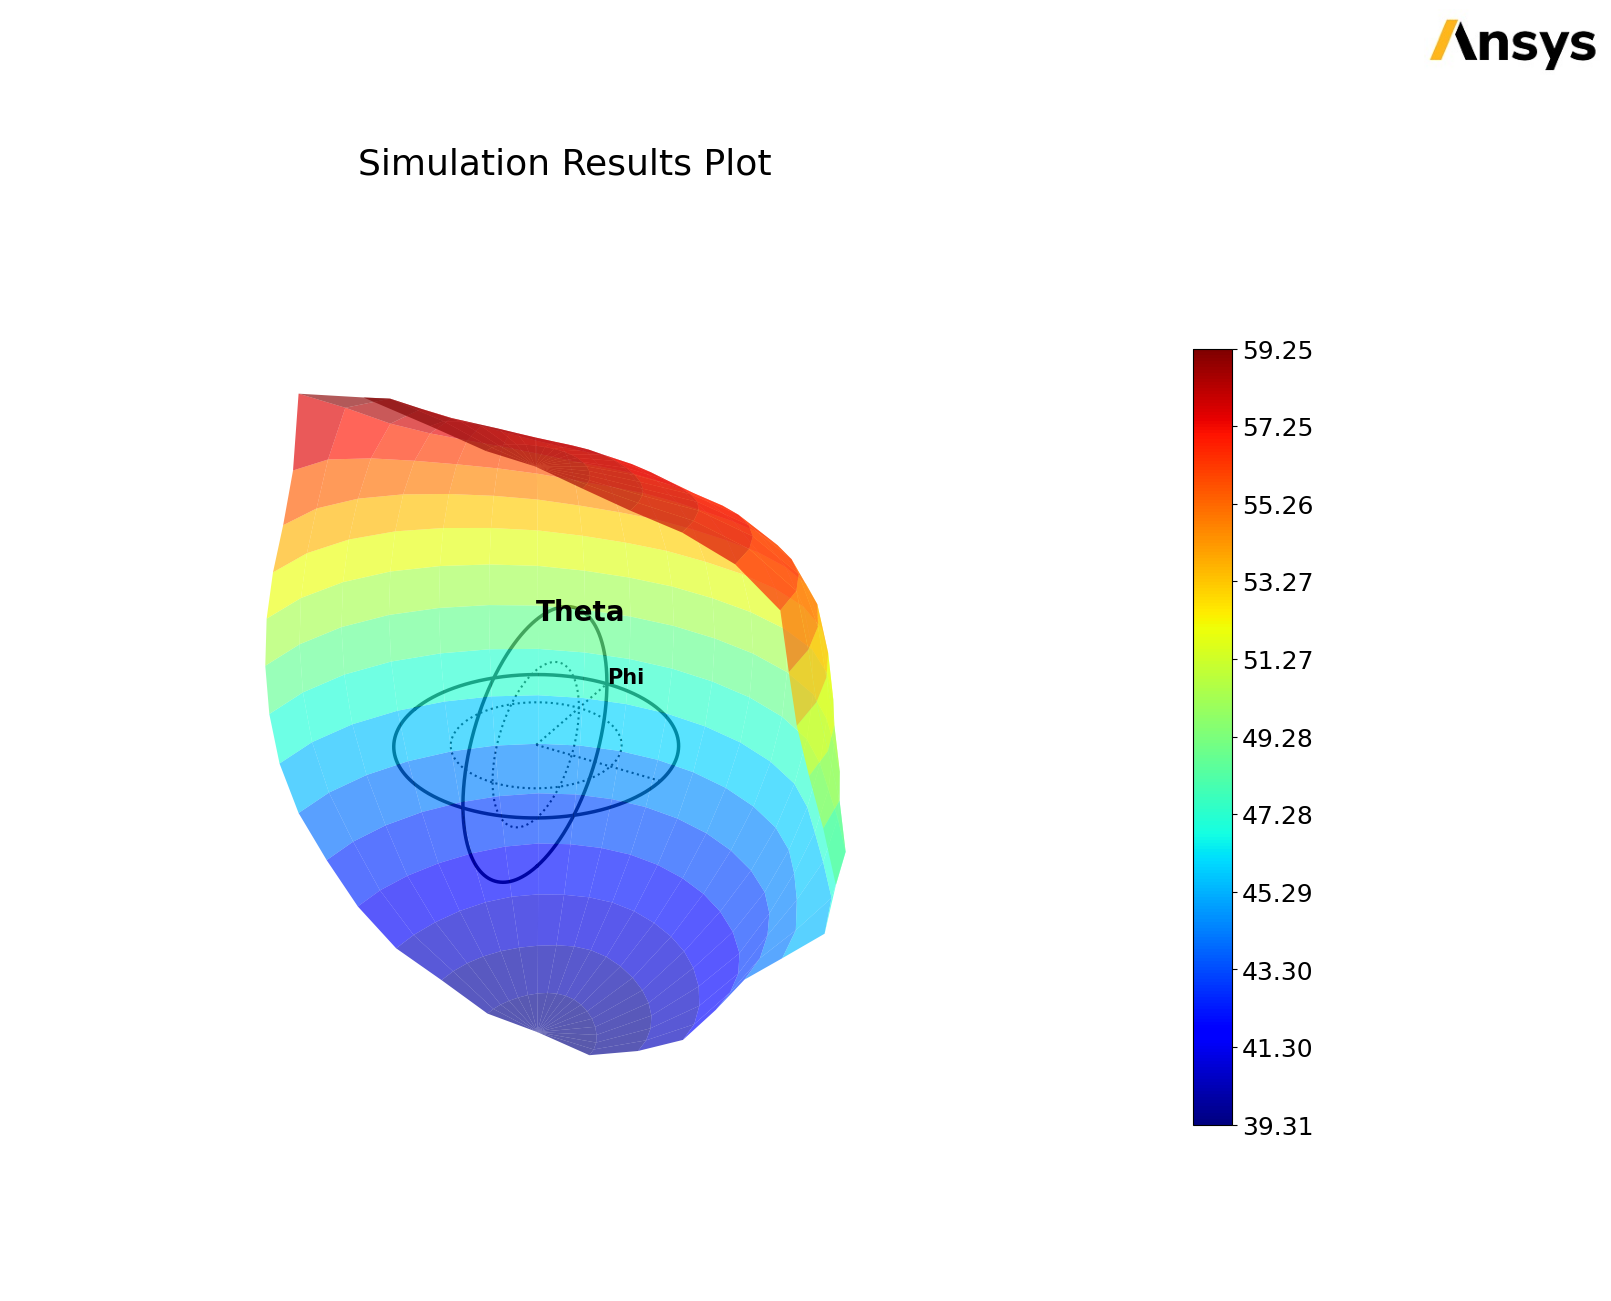

In [27]:
solutions_custom = new_report.get_solution_data()
solutions_custom.plot_3d()

## Plot E Field on nets and layers

Plot E Field on nets and layers in AEDT

In [28]:
h3d.post.create_fieldplot_layers_nets(
    [["TOP", "Array_antenna"]],
    "Mag_E",
    intrinsics={"Freq": "20GHz", "Phase": "0deg"},
    plot_name="E_Layers",
)

## Close AEDT

After the simulation completes, the application can be released from the
:func:`ansys.aedt.core.Desktop.release_desktop` method.
All methods provide for saving the project before closing AEDT.

In [29]:
h3d.save_project(os.path.join(temp_dir.name, "test_layout.aedt"))
h3d.release_desktop()

PyAEDT INFO: Project test_layout Saved correctly


PyAEDT INFO: Desktop has been released and closed.


True

### Clean up the temporary directory

The following command removes the project and the temporary directory.
If you'd like to save this project, save it to a folder of your choice prior
to running the following cell.

In [30]:
temp_dir.cleanup()